In [ ]:
#| default_exp remesh

# Mesh creation and remeshing

> Create meshes from level sets (marching cubes) and improve mesh quality with remeshing, using `igl` as backend

This notebook contains functions for (a) meshing (computing a mesh from a 3d segmentation) and (b) subdividing and simplifying meshes while preserving UV information. The latter is useful since it allows one to increase or decrease the mesh "resolution" as needed when the mesh is deformed.

In [ ]:
#| export

from blender_tissue_cartography import mesh as tcmesh

from scipy import ndimage
import numpy as np
import igl

import warnings

In [ ]:
#| hide
from blender_tissue_cartography import io as tcio
import matplotlib.pyplot as plt

### Meshing using the marching cubes method

A key part of the tissue cartography pipeline is converting a 3d segmentation into a triangular mesh. We do this using the marching cube algorithm. It is essential to convert the mesh vertex coordinates from pixels into microns!

In [ ]:
#| export

def marching_cubes(volume, isovalue=0.5, sigma_smoothing=0):
    """
    Compute triangular mesh of isosurface using marching cubes as implemented by lib|igl.
    
    Parameters
    ----------
    volume : 3d np.array
        Array with scalar values from which to compute the isosurface.
    isovalue: float, default 0.5
        Isosurface to extract
    sigma_smoothing: float, default 0
        If >0, carry out Gaussian smoothing before marching cubes

    Returns
    -------
    np.array, np.array
        vertices : np.array of shape (n_vertices, 3)
            Vertices
        faces : np.array of shape (n_faces, 3)
            Triangular faces (each face is a set of indices into the vertices array)
    """
    pts_grid = np.stack(np.meshgrid(*[np.arange(i) for i in volume.shape], indexing="ij"),
                        axis=-1).reshape(-1,3, order="F").astype(float)
    if sigma_smoothing>0:
        vals = ndimage.gaussian_filter(volume, sigma=sigma_smoothing).flatten(order="F")
    else:
        vals = volume.flatten(order="F")
    vertices, faces = igl.marching_cubes(vals, pts_grid, *volume.shape, isovalue)
    return vertices, faces

Let's test this on an example.

In [ ]:
metadata_dict = {'filename': 'datasets/basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3), # how much you subsampled your image for segmentation
                }

In [ ]:
# load the segmentation created by ilastik (see notebook 01a)

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # Select the first channel of the segmentation - it's the probability a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


In [ ]:
vertices, faces = marching_cubes(segmentation, isovalue=0.5, sigma_smoothing=3)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = tcmesh.ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes_igl"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes_igl.obj")

### Subdivision with `igl`

We'll use the `igl.upsample` function since it can cleanly deal with UV seams. The more sophisticated loop subdivision algorithm messes them up.

In [ ]:
#| export

def subdivide_igl(mesh, reglue=True, decimals=None):
    """
    Refine mesh by edge subdivision using igl.
    
    Subdivides all edges by placing new vertices at edge midpoints. Preserves UV information,
    by cutting the mesh along seams and (optionally) gluing back after. New texture vertices
    are also placed at texture-edge midpoints.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    reglue : bool
        Glue back after cutting
    decimals : int or None
        Decimal precision for merging vertices when regluing. If None, estimate from average
        edge mesh length as -4*log_10(avg length)

    Returns
    -------
    mesh_subdiv : ObjMesh
        Subdivided mesh.
    """
    mesh_cut = mesh.cut_along_seams()
    new_vertices, new_faces = igl.upsample(mesh_cut.vertices, mesh_cut.tris, number_of_subdivs=1)
    new_texture_vertices, _ = igl.upsample(mesh_cut.texture_vertices, mesh_cut.tris, number_of_subdivs=1)
    mesh_subdiv = tcmesh.ObjMesh(vertices=new_vertices, texture_vertices=new_texture_vertices,
                               faces=[[[v,v] for v in fc] for fc in new_faces])
    mesh_subdiv.set_normals()
    if reglue:
        mesh_subdiv = tcmesh.glue_seams(mesh_subdiv, decimals=decimals)
    return mesh_subdiv

In [ ]:
mesh_test = tcmesh.ObjMesh.read_obj("datasets/movie_example/initial_uv.obj")
mesh_subdiv = subdivide_igl(mesh_test, reglue=True)
mesh_subdiv.write_obj("datasets/movie_example/mesh_subdivided_igl.obj", )

  o mesh_01_cylinder_seams_uv


[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

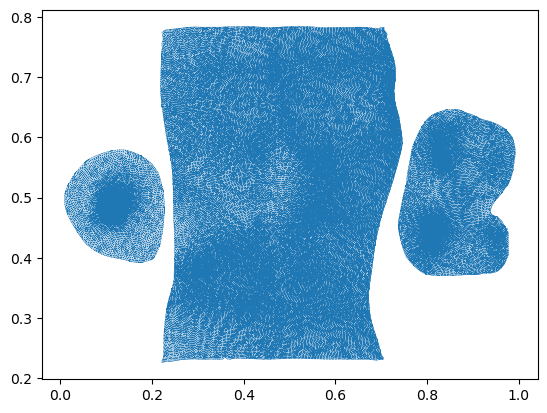

In [ ]:
plt.triplot(*mesh_subdiv.texture_vertices.T, mesh_subdiv.texture_tris, lw=0.2)

### Improve mesh quality by flips

We can change our mesh topology while keeping vertex positions fixed by doing edge flips to avoid deformed triangles. This can be done using the intrinsic Delaunay algorithm. By cutting/regluing the mesh, we can avoid flipping edges along the seam, thus preserving UV information.

Note: this can lead to self-overlaps in the UV-mapped triangulation. this can be fixed by a round of Laplacian smoothing of the UV coordinates.

In [ ]:
#| export

def make_delaunay(mesh):
    """
    Make mesh triangles less deformed by edge flips. 
    
    This algorithm improves mesh quality (i.e. makes triangles less deformed)
    without moving vertices by "edge flips" using the Delaunay algorithm.
    UV information is preserved by forbidding the flip of edges along the
    UV seams.
    
    Note that this algorithm can lead to self-overlap of the UV map.
    You can fix this using wrapping.smooth_laplacian_texture.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.

    Returns
    -------
    mesh_new : ObjMesh
        Mesh with flipped edges.
    """
    if mesh.only_vertices:
        l = igl.edge_lengths(mesh.vertices, mesh.tris)
        l_new, f_new = igl.intrinsic_delaunay_triangulation(l, mesh.tris)
        mesh_new = tcmesh.ObjMesh(vertices=mesh.vertices, faces=f_new)
        return mesh_new
    mesh_cut = mesh.cut_along_seams()
    l = igl.edge_lengths(mesh_cut.vertices, mesh_cut.tris)
    l_new, f_new = igl.intrinsic_delaunay_triangulation(l, mesh_cut.tris)
    mesh_new = tcmesh.ObjMesh(vertices=mesh_cut.vertices, normals=mesh_cut.normals,
                              texture_vertices=mesh_cut.texture_vertices,
                              faces=[[[v,v] for v in fc] for fc in f_new])
    mesh_new = tcmesh.glue_seams(mesh_new, decimals=None)
    return mesh_new

In [ ]:
mesh = tcmesh.ObjMesh.read_obj(f"datasets/movie_example/meshes_wrapped/mesh_20_wrapped.obj")

mesh_new = make_delaunay(mesh)
mesh_new.write_obj(f"datasets/movie_example/mesh_20_wrapped_delaunay.obj")

<matplotlib.collections.PolyCollection>

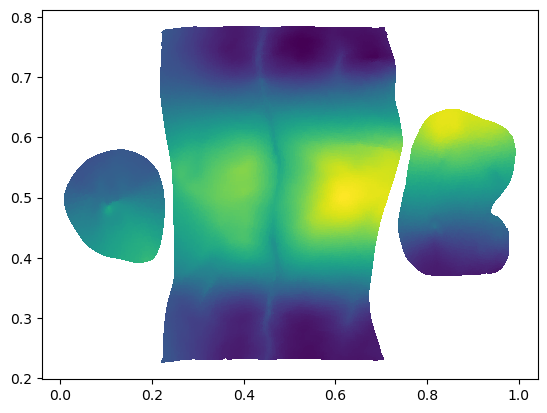

In [ ]:
plt.tripcolor(*mesh_new.texture_vertices.T, mesh_new.texture_tris,
              mesh_new.vertices[mesh_new.get_vertex_to_texture_vertex_indices(),0])

### simplification/decimation with `igl`

Unfortunately, mesh simplification (qslim) in `igl` degrades UV information: Assigning texture coordinates simply based on the birth vertex leads to "jagged" UV maps. Can we do better? I guess not :\

In [ ]:
#| export

def qslim(mesh, max_n_faces):
    """
    Simplify mesh by face decimation using the qslim algorithm.
    
    A wrapper of igl.qslim. This _will_ destroy UV mapping information!
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    max_n_faces : int
        Maximum number of faces in output
    
    Returns
    -------
    mesh_new : ObjMesh
        Decimated mesh.

    """
    _, vertices_new, faces_new, _, _ = igl.qslim(mesh.vertices, mesh.tris, max_m=max_n_faces)
    return tcmesh.ObjMesh(vertices=vertices_new, faces=faces_new)